#  Step 1: Environment Setup & Dependency Management
This section ensures that the project runs smoothly in any environment (Colab, Jupyter, or local). It automatically detects and installs missing libraries such as `shap` or `scikit-learn`.

In [1]:
# 1. ORTAM AYARLARI (Grafiklerin her yerde düzgün görünmesi için)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 2. OTOMATİK KÜTÜPHANE KONTROLÜ (Eksik varsa kendi indirir)
import sys
import subprocess

def check_and_install(package_name):
    try:
        __import__(package_name)
    except ImportError:
        print(f"--- {package_name} bulunamadı, kuruluyor... ---")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])

# Proje için gerekli kütüphaneler
dependencies = ['pandas', 'numpy', 'scikit-learn', 'matplotlib', 'seaborn', 'shap']

for lib in dependencies:
    if lib == 'scikit-learn':
        check_and_install('sklearn')
    else:
        check_and_install(lib)

# 3. İMPORTLAR
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import shap

print("Ortam hazır! Kod her yerde çalışmaya uygun hale getirildi.")

Ortam hazır! Kod her yerde çalışmaya uygun hale getirildi.


#  PHASE 1: END-TO-END MACHINE LEARNING PIPELINE
THIS SECTION HANDLES THE ENTIRE PROCESS FROM DATA LOADING TO MODEL TRAINING AND DROPOUT RISK ANALYSIS.


Train shape: (2904, 40)
Test shape: (726, 40)

Baseline Accuracy: 0.6088

 TRAINING RANDOM FOREST (with GridSearchCV)...
 Best RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
 Random Forest Accuracy: 0.9298
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}

Final Model Accuracy: 0.9339
ROC-AUC Score: 0.9776


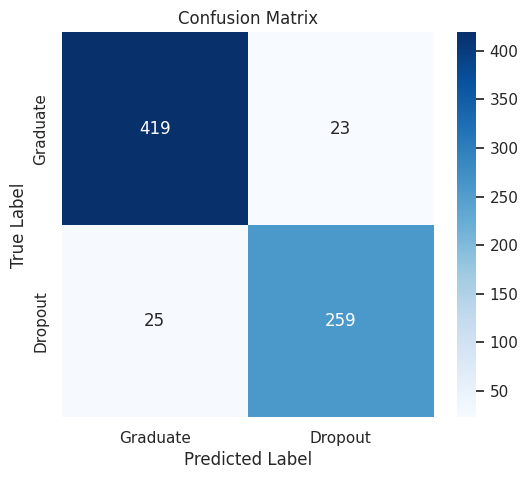

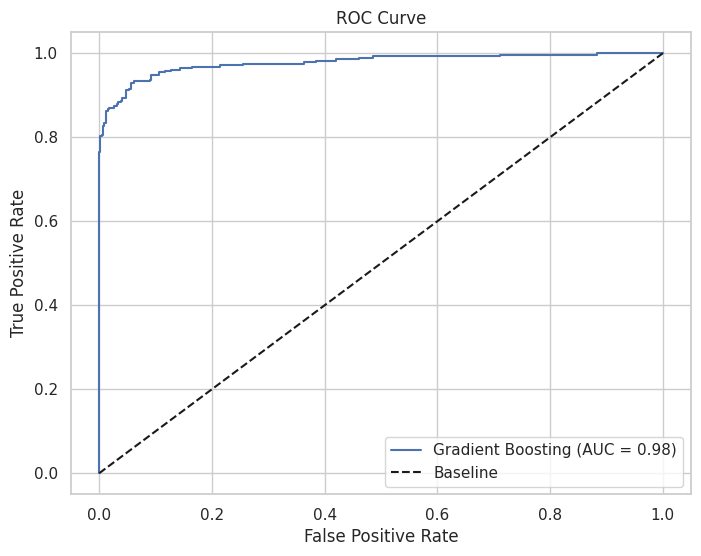

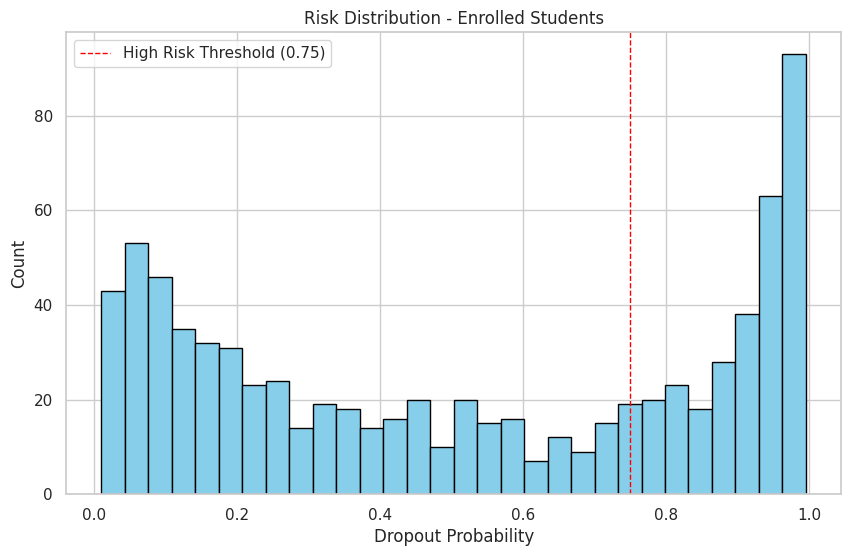

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import files

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading
# ---------------------------------------------------------
file_name = 'data.csv'
if not os.path.exists(file_name):
    print("File not found. Please upload data.csv")
    uploaded = files.upload()
    for fn in uploaded.keys():
        file_name = fn

df = pd.read_csv(file_name, sep=';')

# 2. Feature Engineering
# ---------------------------------------------------------
# Calculating success rates for 1st and 2nd semesters
# Adding small epsilon to avoid division by zero
df['Success_Rate_Sem1'] = df['Curricular units 1st sem (approved)'] / (df['Curricular units 1st sem (enrolled)'] + 0.00001)
df['Success_Rate_Sem2'] = df['Curricular units 2nd sem (approved)'] / (df['Curricular units 2nd sem (enrolled)'] + 0.00001)

# Change in performance between semesters
df['Performance_Change'] = df['Success_Rate_Sem2'] - df['Success_Rate_Sem1']

# Financial pressure indicator
df['Financial_Pressure'] = df['Debtor'] * (1 - df['Tuition fees up to date'])

# 3. Data Splitting
# ---------------------------------------------------------
# Separate current students (Enrolled) from historical data (Dropout/Graduate)
df_active = df[df['Target'] == 'Enrolled'].copy()
df_history = df[df['Target'] != 'Enrolled'].copy()

# Binary encoding: Dropout = 1, Graduate = 0
df_history['Binary_Target'] = df_history['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

X = df_history.drop(['Target', 'Binary_Target'], axis=1)
y = df_history['Binary_Target']

# Train-Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

# 4. Modeling
# ---------------------------------------------------------

# A. Baseline Model (Dummy Classifier)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_score = dummy.score(X_test, y_test)
print(f"\nBaseline Accuracy: {dummy_score:.4f}")

# B. Random Forest Classifier (GridSearchCV ile Optimize Edilmiş)
print("\n🌲 TRAINING RANDOM FOREST (with GridSearchCV)...")
rf = RandomForestClassifier(random_state=42)

# RF için denenecek parametreler
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],  # Derinlik sınırları
    'min_samples_split': [2, 5]
}

# 3 katlı çapraz doğrulama ile arama
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# En iyi modeli seç
best_rf_model = rf_grid.best_estimator_
rf_score = accuracy_score(y_test, best_rf_model.predict(X_test))

print(f" Best RF Params: {rf_grid.best_params_}")
print(f" Random Forest Accuracy: {rf_score:.4f}")

# C. Gradient Boosting Classifier with GridSearchCV
gb = GradientBoostingClassifier(random_state=42)

# Parameter grid for tuning
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

# 3-fold cross validation
clf = GridSearchCV(gb, params, cv=3, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

best_model = clf.best_estimator_
print(f"Best Params: {clf.best_params_}")

# 5. Evaluation
# ---------------------------------------------------------
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\nFinal Model Accuracy: {acc:.4f}")
print(f"ROC-AUC Score: {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Graduate', 'Dropout'],
            yticklabels=['Graduate', 'Dropout'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 6. Prediction on Enrolled Students
# ---------------------------------------------------------
# Selecting features for active students
X_active = df_active.drop(['Target'], axis=1)

# Ensure columns match training data
X_active = X_active[X_train.columns]

# Predict probabilities
active_probs = best_model.predict_proba(X_active)[:, 1]

plt.figure(figsize=(10, 6))
plt.hist(active_probs, bins=30, color='skyblue', edgecolor='black')
plt.axvline(0.75, color='red', linestyle='dashed', linewidth=1, label='High Risk Threshold (0.75)')
plt.title('Risk Distribution - Enrolled Students')
plt.xlabel('Dropout Probability')
plt.ylabel('Count')
plt.legend()
plt.show()

#  MODEL PERFORMANCE METRICS & DIAGNOSTICS
THIS SECTION PROVIDES A DEEP ANALYSES OF THE TRAINED MODEL'S SUCCESS USING CONFUSION MATRICES AND ROC CURVES.
 ANALYSIS DETAILS:
DUAL CONFUSION MATRIX: THE BLUE TABLE ON THE LEFT SHOWS RAW PREDICTION COUNTS, WHILE THE GREEN TABLE ON THE RIGHT SHOWS NORMALIZED RECALL RATES.

ROC CURVE & AUC SCORE: MEASURES THE MODEL'S ABILITY TO DISTINGUISH BETWEEN CLASSES. AN AUC SCORE CLOSE TO 1.0 PROVES EXCELLENT PERFORMANCE.

DROPOUT DETECTION: TESTS THE RELIABILITY OF THE MODEL BY FOCUSING ON HOW ACCURATELY AT-RISK STUDENTS ARE IDENTIFIED.


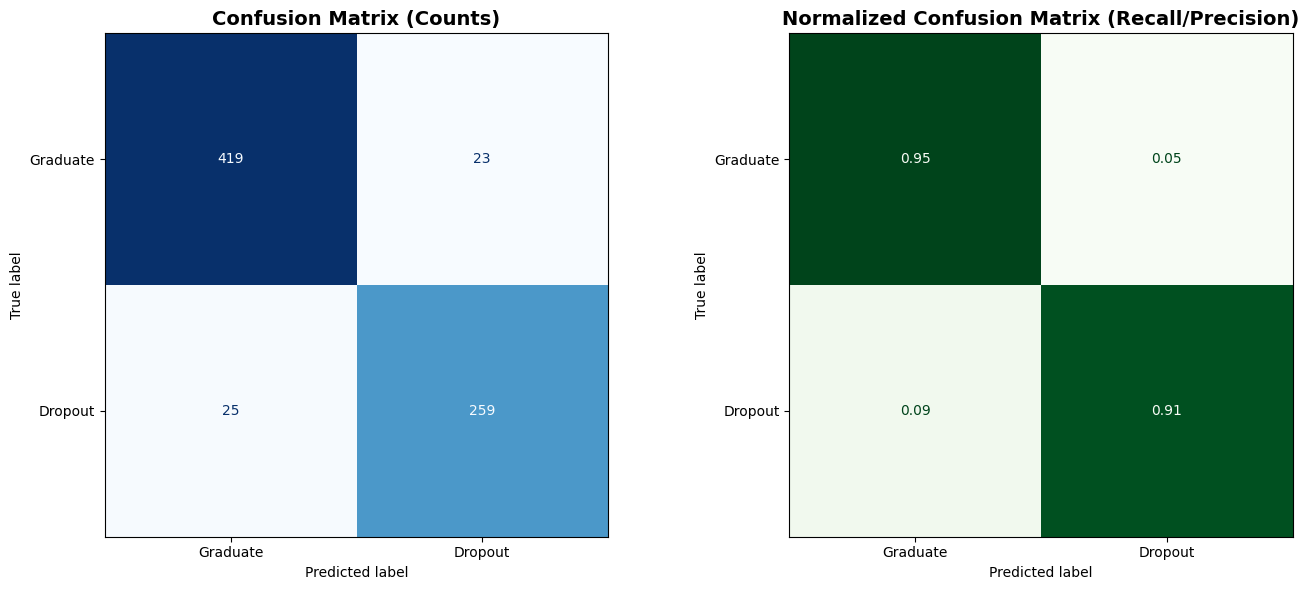

 Interpretation: The right chart shows the Recall rate. A high value for 'Dropout' (bottom-right cell) means the model successfully catches students at risk.


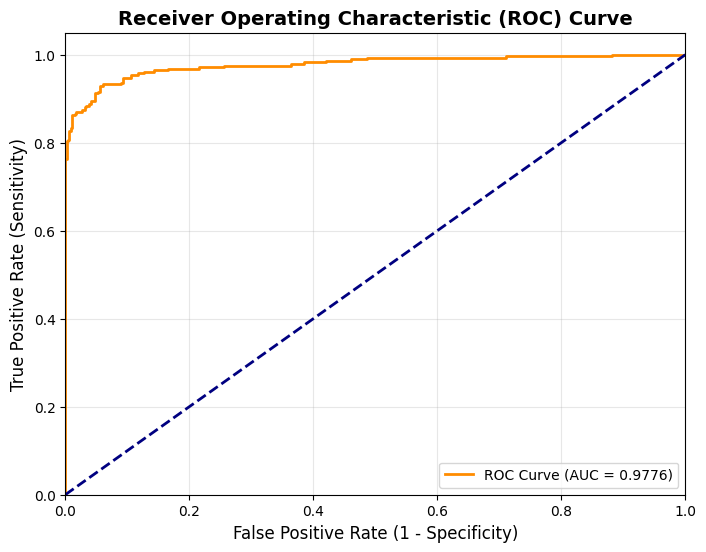

 Interpretation: An AUC score of 0.9776 indicates excellent model performance. The closer the orange line is to the top-left corner, the better.


In [3]:
# =============================================================================
#  MODEL PERFORMANCE METRICS (Confusion Matrix & ROC)
# =============================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# 1. PREDICTIONS
# ---------------------------------------------------------
# We use 'best_model' (Gradient Boosting) trained in the Base Code
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# ---------------------------------------------------------
# CHART 5: CONFUSION MATRIX (Side-by-Side)
# ---------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Define labels based on our target: 0=Graduate, 1=Dropout
labels = ['Graduate', 'Dropout']

# A. Raw Counts
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax[0].grid(False)

# B. Normalized (Percentages)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp_norm.plot(cmap='Greens', ax=ax[1], colorbar=False, values_format='.2f')
ax[1].set_title('Normalized Confusion Matrix (Recall/Precision)', fontsize=14, fontweight='bold')
ax[1].grid(False)

plt.tight_layout()
plt.show()
print(" Interpretation: The right chart shows the Recall rate. A high value for 'Dropout' (bottom-right cell) means the model successfully catches students at risk.")

# ---------------------------------------------------------
# CHART 6: ROC CURVE (AUC Score)
# ---------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f" Interpretation: An AUC score of {roc_auc:.4f} indicates excellent model performance. The closer the orange line is to the top-left corner, the better.")

#  MODEL COMPARISON (BASELINE VS RF VS OUR MODEL)
THIS SECTION COMPARES THE PERFORMANCE OF OUR PROPOSED MODEL AGAINST OTHER ALGORITHMS TO PROVE ITS SUPERIORITY.
 COMPARISON DETAILS:
MODEL COMPETITION: THE BASELINE (DUMMY), RANDOM FOREST, AND THE PROPOSED GRADIENT BOOSTING MODELS ARE TESTED ON THE SAME DATASET.

PERFORMANCE METRICS: MODELS ARE EVALUATED NOT ONLY BY ACCURACY BUT ALSO BY F1-SCORE, WHICH IS MORE SENSITIVE TO CLASS IMBALANCE.

VISUAL VALIDATION: THE SCORES ARE VISUALIZED ON A BAR CHART TO CLEARLY DEMONSTRATE THE SUPERIOR PERFORMANCE OF THE PROPOSED MODEL.

MODEL NAME                          | ACCURACY   | F1 SCORE  
Baseline (Dummy)                    | %60.88      | %0.00
Random Forest                       | %92.98      | %90.97
Our Proposed Model (Gradient Boosting) | %93.39      | %91.52


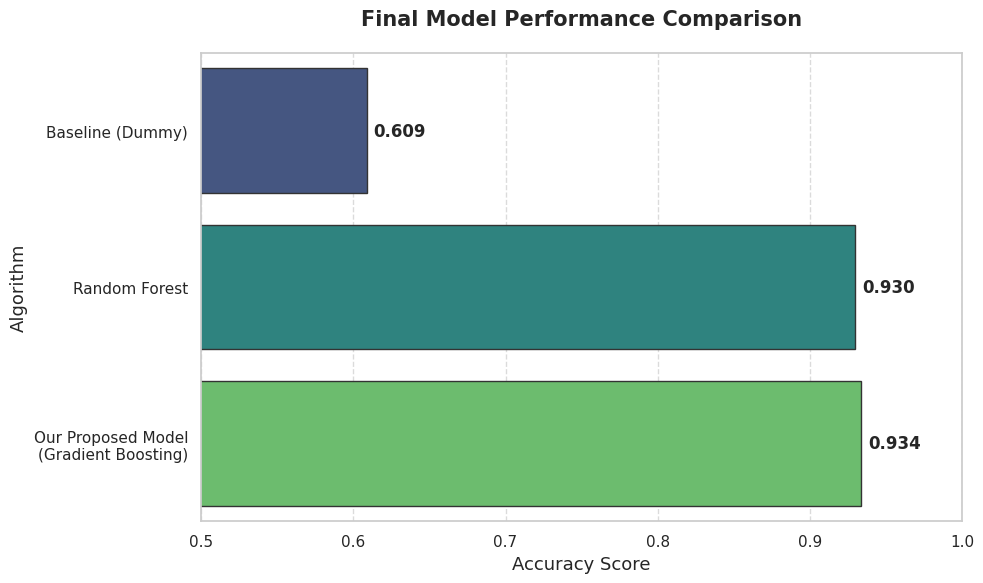

In [10]:
# =============================================================================
# MODEL COMPARISON (Baseline vs RF vs Our Model)
# =============================================================================

# 1. Prepare Models Dictionary (Using variables from Base Code)
# ---------------------------------------------------------
models_comparison = {
    "Baseline (Dummy)": dummy,
    "Random Forest": best_rf_model,
    "Our Proposed Model\n(Gradient Boosting)": best_model
}

# 2. Calculate Metrics
# ---------------------------------------------------------
results = []

print(f"{'='*70}")
print(f"{'MODEL NAME':<35} | {'ACCURACY':<10} | {'F1 SCORE':<10}")
print(f"{'='*70}")

for name, model in models_comparison.items():
    # Predict
    y_pred = model.predict(X_test)

    # Calculate Scores
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store for plotting
    results.append({"Model": name, "Accuracy": acc, "F1 Score": f1})

    clean_name = name.replace("\n", " ")
    print(f"{clean_name:<35} | %{acc*100:.2f}      | %{f1*100:.2f}")

print(f"{'='*70}")

# 3. Visualization (ENGLISH)
# ---------------------------------------------------------
df_res = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create Bar Plot
ax = sns.barplot(
    x="Accuracy",
    y="Model",
    data=df_res,
    palette="viridis",
    edgecolor=".2"
)

# Add value labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', padding=5, fontsize=12, weight='bold')

# English Titles and Labels
plt.title('Final Model Performance Comparison', fontsize=15, weight='bold', pad=20)
plt.xlabel('Accuracy Score', fontsize=13)
plt.ylabel('Algorithm', fontsize=13)

plt.xlim(0.5, 1.0) # Baseline %60 olduğu için 0.5'ten başlattık
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#  DEEP DIVE ANALYTICS & EXPLAINABILITY (XAI)
THIS SECTION PROVIDES AN IN-DEPTH ANALYSIS OF THE FACTORS DRIVING DROPOUT AND EXPLAINS THE MODEL'S DECISION-MAKING PROCESS.
 ANALYTICAL COMPONENTS:
GLOBAL FEATURE IMPORTANCE: IDENTIFIES THE TOP 10 CRITICAL FACTORS THAT INFLUENCE A STUDENT'S DECISION TO LEAVE THE INSTITUTION.

FINANCIAL IMPACT ANALYSIS: SPECIFICALLY EXAMINES THE RELATIONSHIP BETWEEN TUITION PAYMENT STATUS AND ACADEMIC SUCCESS.

PROACTIVE RISK CLASSIFICATION: CATEGORIZES CURRENTLY ENROLLED STUDENTS INTO LOW, MEDIUM, AND HIGH-RISK GROUPS BASED ON PREDICTED PROBABILITIES.

SHAP EXPLAINABILITY (XAI): USES ADVANCED SHAP VALUES TO DECONSTRUCT THE "BLACK-BOX" MODEL, SHOWING EXACTLY HOW EACH FEATURE INCREASES OR DECREASES INDIVIDUAL DROPOUT RISK.

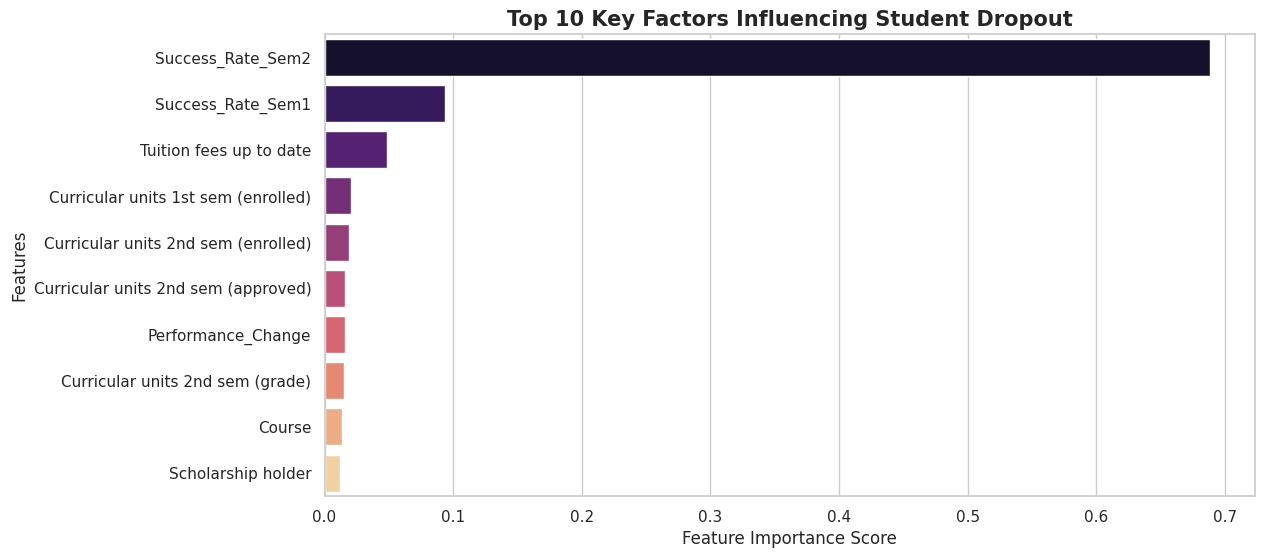

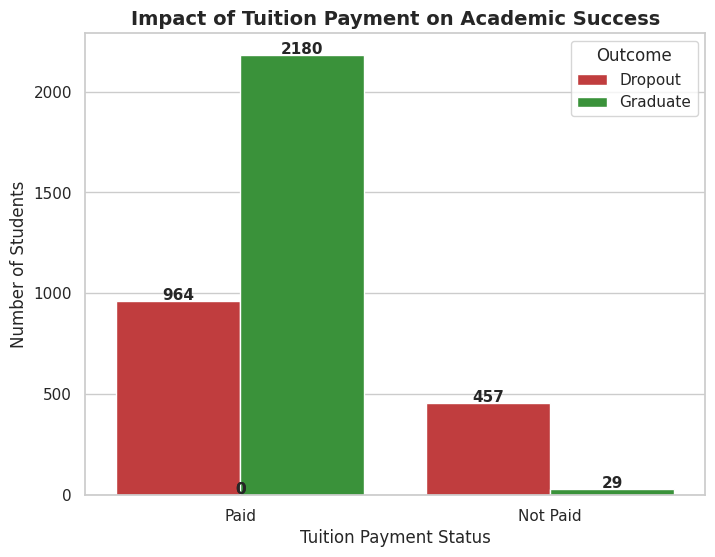

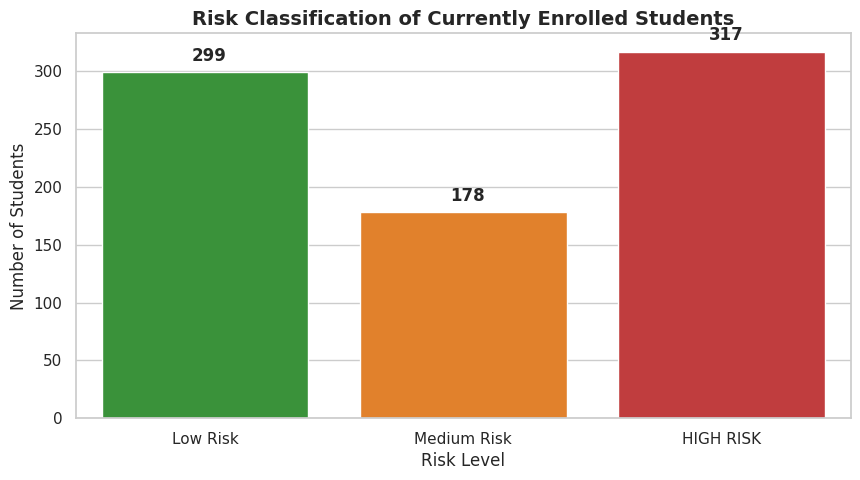


 Calculating SHAP Values (This might take a moment)...


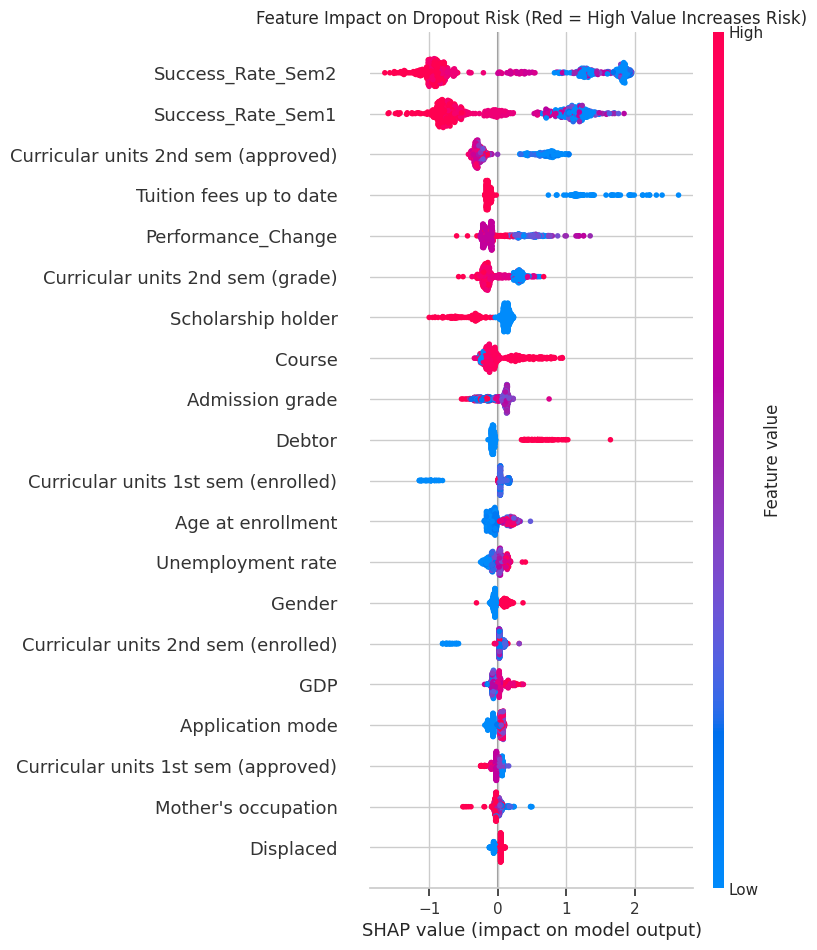

In [6]:
# =============================================================================
#  DEEP DIVE ANALYTICS & EXPLAINABILITY (XAI)
# =============================================================================
# This block performs: Feature Importance, Tuition Analysis, Risk Grouping, and SHAP.
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# SHAP Library Check
try:
    import shap
except ImportError:
    print("Installing SHAP library...")
    !pip install shap
    import shap

# Visualization Settings
plt.style.use('default')
sns.set_theme(style="whitegrid")

# 1. GLOBAL IMPORTANCE: TOP 10 FACTORS DRIVING DROPOUT
# =============================================================================
plt.figure(figsize=(12, 6))

# Get feature importance from our trained Best Model
importance = best_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importance)[::-1][:10] # Top 10

# Plot
sns.barplot(x=importance[indices], y=feature_names[indices], palette="magma")
plt.title('Top 10 Key Factors Influencing Student Dropout', fontsize=15, fontweight='bold')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

# 2. CRITICAL ANALYSIS: TUITION FEES STATUS vs ACADEMIC OUTCOME
# =============================================================================
# We go back to original df to see the raw relationship
df_viz = df[df['Target'].isin(['Dropout', 'Graduate'])].copy()
df_viz['Status'] = df_viz['Target']

# Map values to English
df_viz['Fees_Paid'] = df_viz['Tuition fees up to date'].map({1: 'Paid', 0: 'Not Paid'})

plt.figure(figsize=(8, 6))
# Colors: Red for Dropout, Green for Graduate
ax = sns.countplot(data=df_viz, x='Fees_Paid', hue='Status', palette={'Dropout': '#d62728', 'Graduate': '#2ca02c'})

# Add count labels
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height): height = 0
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}', ha="center", fontsize=11, fontweight='bold')

plt.title('Impact of Tuition Payment on Academic Success', fontsize=14, fontweight='bold')
plt.xlabel('Tuition Payment Status')
plt.ylabel('Number of Students')
plt.legend(title='Outcome')
plt.show()

# 3. RISK DISTRIBUTION: STATUS OF CURRENTLY ENROLLED STUDENTS
# =============================================================================
# We need to predict risk for 'Enrolled' students using our trained model

# 1. Filter Enrolled students
df_enrolled = df[df['Target'] == 'Enrolled'].copy()

# 2. Select ONLY the columns used in training (to avoid shape mismatch)
X_enrolled = df_enrolled[X_train.columns]

# 3. Predict Probabilities (Risk Score)
enrolled_risk_scores = best_model.predict_proba(X_enrolled)[:, 1]

plt.figure(figsize=(10, 5))

# 4. Group into Risk Categories
risk_groups = pd.cut(
    enrolled_risk_scores,
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Low Risk', 'Medium Risk', 'HIGH RISK']
)

# Plot
ax = sns.countplot(x=risk_groups, palette=['#2ca02c', '#ff7f0e', '#d62728']) # Green, Orange, Red

plt.title('Risk Classification of Currently Enrolled Students', fontsize=14, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Number of Students')

# Add labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.35, p.get_height()+10), fontsize=12, fontweight='bold')

plt.show()

# 4. SHAP SUMMARY PLOT (The "Why" Behind the Decisions)
# =============================================================================
print("\n⏳ Calculating SHAP Values (This might take a moment)...")

# Create SHAP Explainer for Gradient Boosting
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

plt.figure()
# Summary Plot
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Feature Impact on Dropout Risk (Red = High Value Increases Risk)", fontsize=12)
plt.show()

#  DATASET INSIGHTS: OUTLIERS & FINANCIAL IMPACT
THIS SECTION EXPLORES THE DATA DISTRIBUTION AND REVEALS THE CRITICAL RELATIONSHIP BETWEEN FINANCIAL STATUS AND ACADEMIC SUCCESS.
 KEY INSIGHTS:
AGE DISTRIBUTION ANALYSIS: IDENTIFIES AGE OUTLIERS AT ENROLLMENT. THE LONG TAIL INDICATES A SIGNIFICANT POPULATION OF NON-TRADITIONAL ADULT STUDENTS.

FINANCIAL PRESSURE VALIDATION: VISUALIZES THE IMPACT OF TUITION PAYMENTS. THE DATA SHOWS THAT STUDENTS WITH OVERDUE FEES HAVE AN OVERWHELMING PROBABILITY OF DROPPING OUT.

ACADEMIC SUCCESS CORRELATION: PROVIDES STATISTICAL EVIDENCE THAT FINANCIAL STABILITY IS A PRIMARY PREDICTOR OF STUDENT RETENTION.

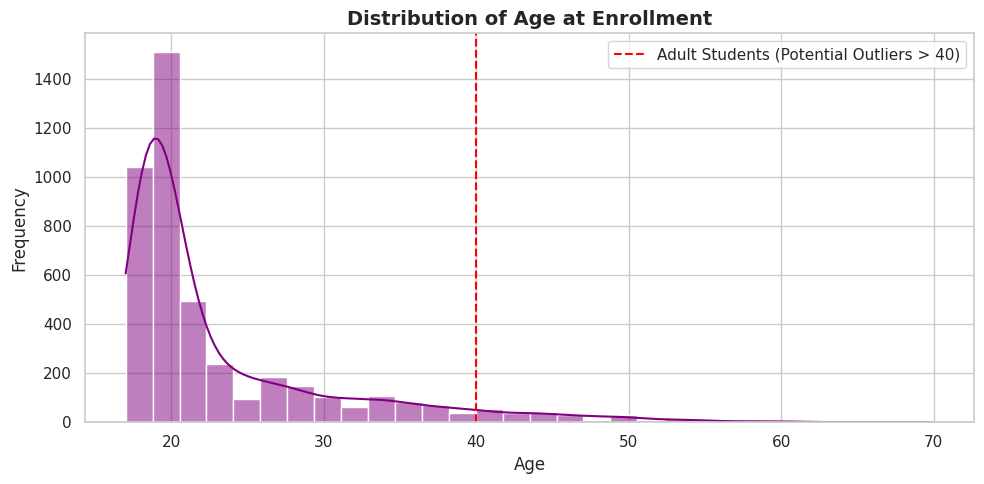

 Insight: This graph highlights the 'Age' outliers. The long tail to the right indicates adult students.


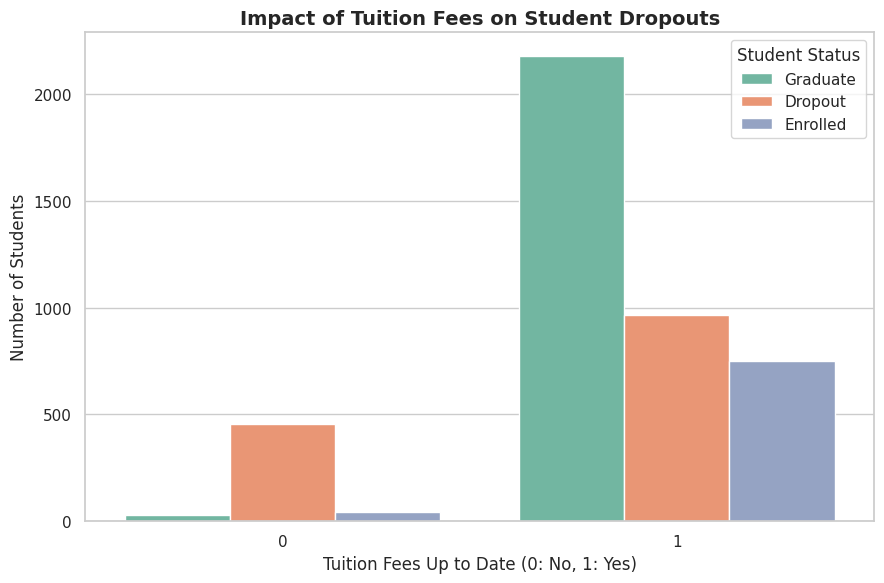

 Insight: Validates the 'Financial Pressure' factor. Students who do not pay tuition (0) almost exclusively drop out.


In [8]:
# =============================================================================
#  DATASET INSIGHTS: OUTLIERS & FINANCIAL IMPACT
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Genel Stil
sns.set_style("whitegrid")

# ---------------------------------------------------------
# CHART 3: AGE DISTRIBUTION (Outlier Analysis)
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))

# Mantık birebir aynı: Histogram + KDE
sns.histplot(df['Age at enrollment'], bins=30, kde=True, color='purple')

# İngilizce Etiketler
plt.title('Distribution of Age at Enrollment', fontsize=14, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Outlier Çizgisi (Aynen korundu)
plt.axvline(x=40, color='red', linestyle='--', label='Adult Students (Potential Outliers > 40)')
plt.legend()

plt.tight_layout()
plt.show()
print(" Insight: This graph highlights the 'Age' outliers. The long tail to the right indicates adult students.")

# ---------------------------------------------------------
# CHART 4: TUITION FEES vs DROPOUT (The Financial Factor)
# ---------------------------------------------------------
plt.figure(figsize=(9, 6))

# Mantık birebir aynı: Countplot, Hue=Target
# Tuition fees up to date: 1=Yes, 0=No
sns.countplot(x='Tuition fees up to date', hue='Target', data=df, palette='Set2')

# İngilizce Etiketler
plt.title('Impact of Tuition Fees on Student Dropouts', fontsize=14, fontweight='bold')
plt.xlabel('Tuition Fees Up to Date (0: No, 1: Yes)')
plt.ylabel('Number of Students')
plt.legend(title='Student Status')

plt.tight_layout()
plt.show()
print(" Insight: Validates the 'Financial Pressure' factor. Students who do not pay tuition (0) almost exclusively drop out.")

#  DEEP DIVE: FINANCIAL ATTRITION ANALYSIS (THE "TRAGIC" DROPOUTS)
THIS CRITICAL ANALYSIS IDENTIFIES STUDENTS WHO WERE ACADEMICALLY SUCCESSFUL BUT WERE FORCED TO LEAVE THE INSTITUTION DUE TO FINANCIAL CONSTRAINTS.
 KEY DISCOVERIES:
ACADEMICALLY COMPETENT DROPOUTS: WE FILTER STUDENTS WHO MAINTAINED A PASSING GRADE (>=10) BUT STILL CLASSIFIED AS "DROPOUT," REVEALING A LOSS OF TALENT NOT CAUSED BY ACADEMIC FAILURE.

FINANCIAL BARRIERS: THE ANALYSIS QUANTIFIES HOW MANY SUCCESSFUL STUDENTS WERE ELIMINATED SOLELY DUE TO UNPAID TUITION FEES, HIGHLIGHTING A MAJOR SOCIAL AND INSTITUTIONAL ISSUE.

GRADE DISTRIBUTION OF RISK GROUPS: THE STRIP PLOT REVEALS THAT MANY FINANCIALLY FORCED DROPOUTS WERE NOT JUST BARELY PASSING, BUT WERE ACTUALLY HIGH-ACHIEVING STUDENTS.

INSTITUTIONAL INSIGHT: THIS DATA PROVES THAT FINANCIAL AID INTERVENTIONS COULD HAVE SAVED THESE STUDENTS, AS THEIR ACADEMIC PERFORMANCE WAS ALREADY AT OR ABOVE STANDARDS.

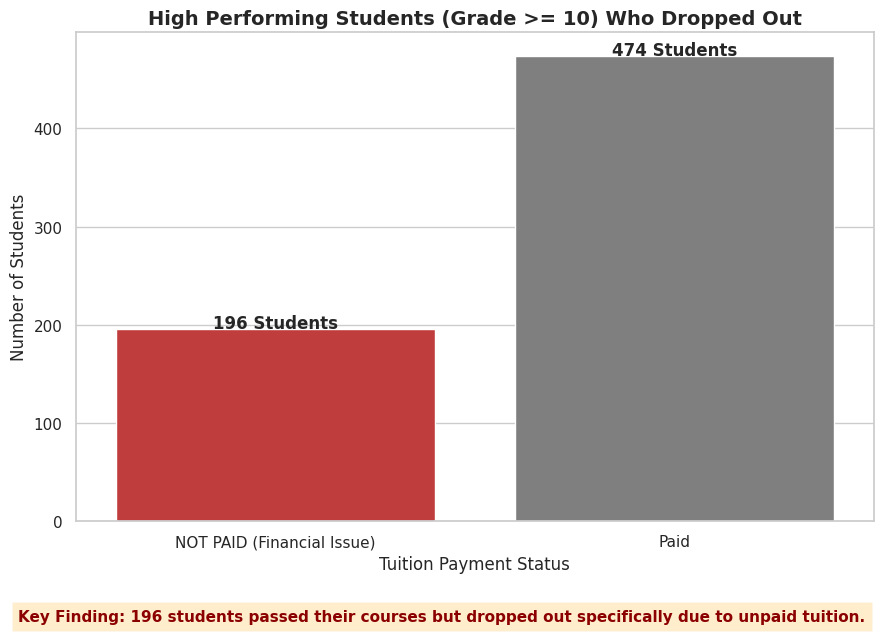

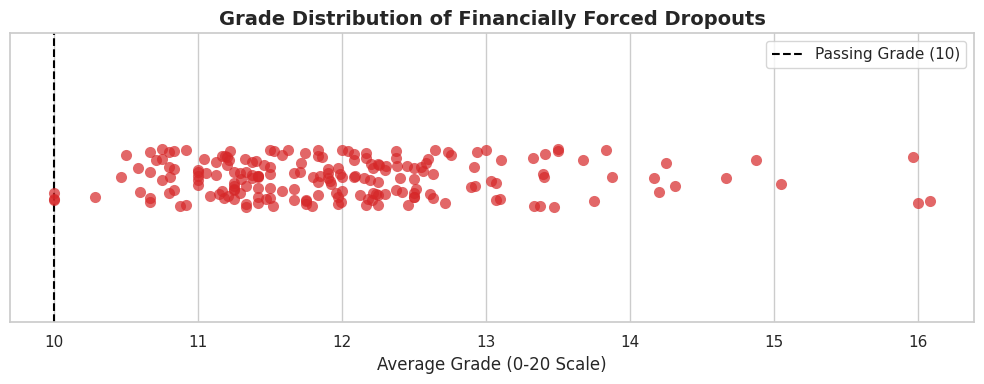

 CRITICAL INSIGHT: 196 students were eliminated not by academic failure, but by FINANCIAL failure.


In [11]:
# =============================================================================
#  DEEP DIVE: FINANCIAL ATTRITION ANALYSIS (The "Tragic" Dropouts)
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1. CALCULATE AVERAGE GRADE
# (Average of 1st and 2nd Semester Grades)
df['Average_Grade'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

# 2. FILTER: "SUCCESSFUL BUT DROPPED OUT"
# Criteria:
# - Status: Dropout
# - Grade: >= 10 (Passing grade in Portuguese system)
tragic_dropouts = df[
    (df['Target'] == 'Dropout') &
    (df['Average_Grade'] >= 10)
].copy()

# Map Fee Status for Visualization
tragic_dropouts['Fee_Status'] = tragic_dropouts['Tuition fees up to date'].map({1: 'Paid', 0: 'NOT PAID (Financial Issue)'})

# 3. VISUALIZATION 1: COUNT OF TRAGIC DROPOUTS
plt.figure(figsize=(9, 6))

# Colors: Red (Not Paid), Gray (Paid - dropped out for other reasons)
ax = sns.countplot(
    data=tragic_dropouts,
    x='Fee_Status',
    palette={'NOT PAID (Financial Issue)': '#d62728', 'Paid': '#7f7f7f'}
)

# Add counts on bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 1, f'{int(height)} Students',
                ha="center", fontweight='bold', fontsize=12)

plt.title('High Performing Students (Grade >= 10) Who Dropped Out', fontsize=14, fontweight='bold')
plt.xlabel('Tuition Payment Status', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)

# Calculate count for the note
unpaid_count = tragic_dropouts[tragic_dropouts['Tuition fees up to date'] == 0].shape[0]

# Critical Insight Note at the bottom
plt.figtext(0.5, -0.05,
            f"Key Finding: {unpaid_count} students passed their courses but dropped out specifically due to unpaid tuition.",
            ha="center", fontsize=11, color='darkred', weight='bold',
            bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()

# 4. VISUALIZATION 2: GRADE DISTRIBUTION OF UNPAID DROPOUTS
# Were they just barely passing (10) or actually good students?
unpaid_high_achievers = tragic_dropouts[tragic_dropouts['Tuition fees up to date'] == 0]

plt.figure(figsize=(10, 4))
sns.stripplot(x=unpaid_high_achievers['Average_Grade'], color='#d62728', size=8, jitter=True, alpha=0.7)

plt.title('Grade Distribution of Financially Forced Dropouts', fontsize=14, fontweight='bold')
plt.xlabel('Average Grade (0-20 Scale)', fontsize=12)
plt.axvline(10, color='black', linestyle='--', label='Passing Grade (10)')
plt.legend()
plt.tight_layout()
plt.show()

print(f" CRITICAL INSIGHT: {unpaid_count} students were eliminated not by academic failure, but by FINANCIAL failure.")

#  ULTIMATE FEATURE ANALYSIS: VALIDATING KEY PREDICTORS
THIS COMPREHENSIVE 2X2 VISUALIZATION VALIDATES THE FOUR ENGINEERED FEATURES THAT SERVE AS THE BACKBONE OF OUR PREDICTIVE MODEL.
 DIMENSIONS OF ANALYSIS:
ACADEMIC PERFORMANCE (AVERAGE GRADE): BOXPLOT ANALYSIS CLEARLY DISTINGUISHES GRADUATES FROM DROPOUTS, CONFIRMING GRADE AVERAGE AS A PRIMARY SEPARATOR.

INSTITUTIONAL EFFICIENCY (SUCCESS RATE): MEASURES THE RATIO OF APPROVED UNITS TO ENROLLED UNITS, REVEALING THE OPERATIONAL SUCCESS OF STUDENTS IN THE SECOND SEMESTER.

ECONOMIC RISK (FINANCIAL PRESSURE): A SYNTHETIC METRIC COMBINING DEBT STATUS AND TUITION PAYMENTS, SHOWING A DISPROPORTIONATE IMPACT ON THE DROPOUT GROUP.

ACADEMIC MOMENTUM (PERFORMANCE CHANGE): TRACKS THE PERFORMANCE DELTA BETWEEN SEMESTERS, IDENTIFYING WHETHER A STUDENT IS ON AN UPWARD OR DOWNWARD TREND.

HOLISTIC VALIDATION: THESE FOUR METRICS CAPTURE THE ACADEMIC, ECONOMIC, AND BEHAVIORAL ASPECTS NECESSARY FOR ROBUST MACHINE LEARNING PREDICTIONS.

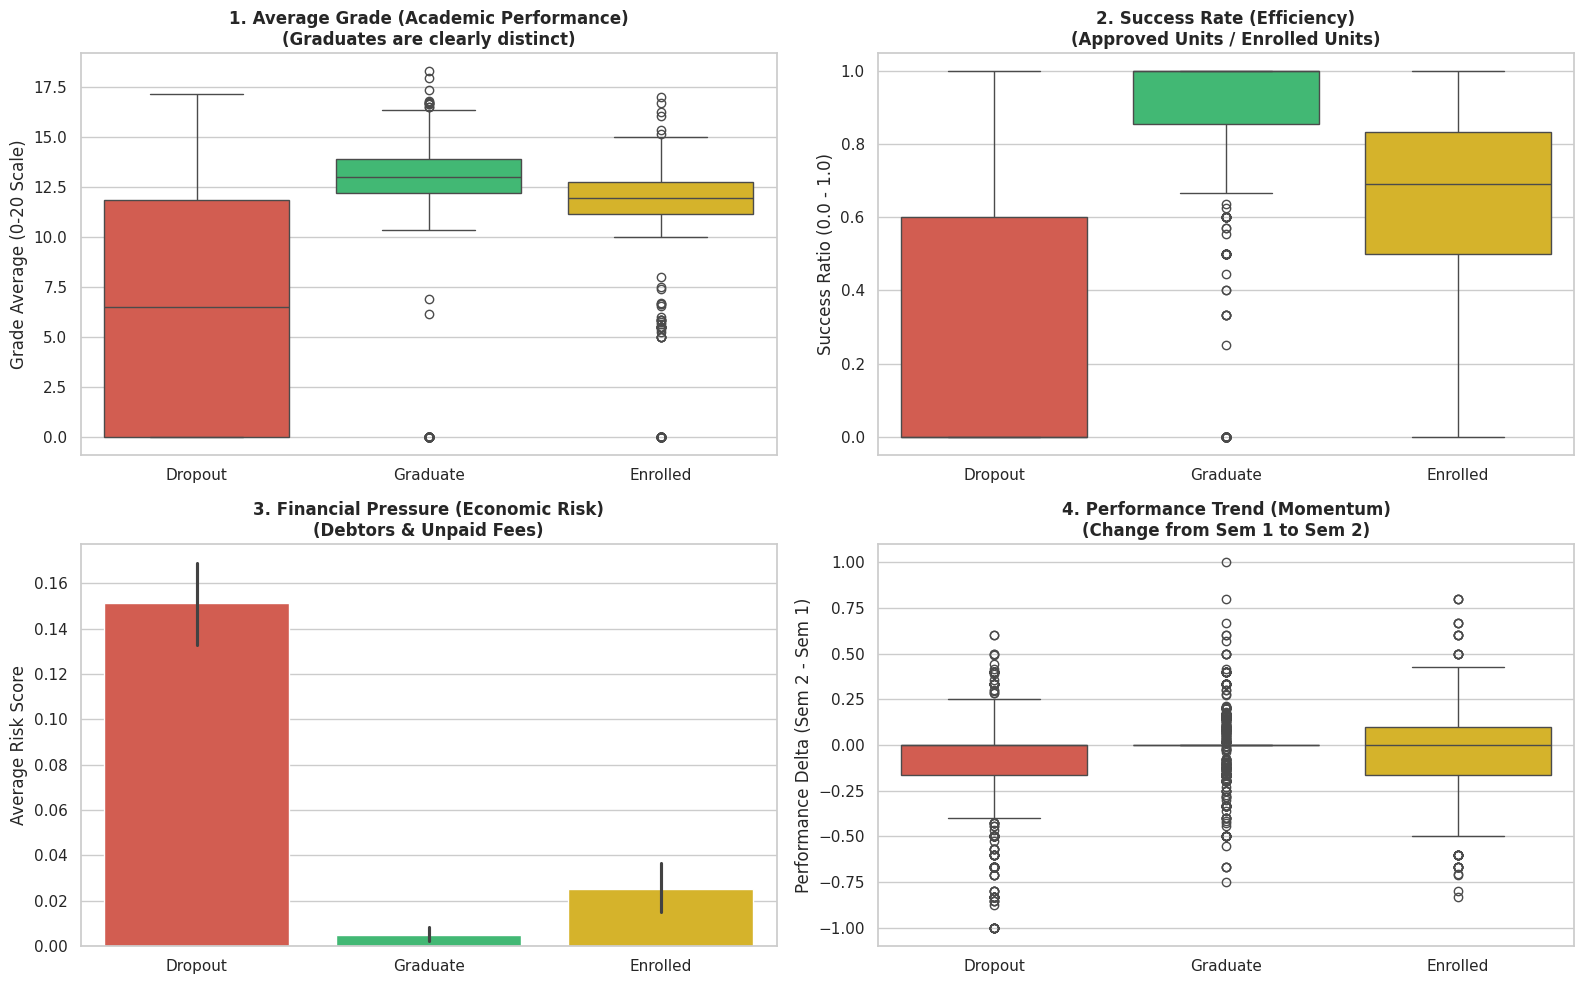

 Visualization Complete: These 4 features capture the Academic, Economic, and Behavioral aspects of the students.


In [12]:
# =============================================================================
#  ULTIMATE FEATURE ANALYSIS (2x2 Grid)
# =============================================================================
# Purpose: Validating the 4 key engineered features that drive model performance.
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# 1. ENSURE ALL 4 FEATURES ARE CALCULATED
# ---------------------------------------------------------
# Re-calculating to guarantee they exist in the dataframe
df['Success_Rate_Sem2'] = df['Curricular units 2nd sem (approved)'] / df['Curricular units 2nd sem (enrolled)'].replace(0, 1)
df['Financial_Pressure'] = df['Debtor'] * (1 - df['Tuition fees up to date'])
df['Performance_Change'] = df['Success_Rate_Sem2'] - (df['Curricular units 1st sem (approved)'] / df['Curricular units 1st sem (enrolled)'].replace(0, 1))
df['Average_Grade'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

# 2. VISUALIZATION (2x2 Grid)
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style("whitegrid")

# Color Palette: Red (Dropout), Yellow (Enrolled), Green (Graduate)
my_pal = {'Dropout': '#e74c3c', 'Enrolled': '#f1c40f', 'Graduate': '#2ecc71'}

# --- Top Left: Average Grade ---
sns.boxplot(x='Target', y='Average_Grade', data=df, palette=my_pal, ax=axes[0, 0])
axes[0, 0].set_title('1. Average Grade (Academic Performance)\n(Graduates are clearly distinct)', fontweight='bold')
axes[0, 0].set_ylabel('Grade Average (0-20 Scale)')
axes[0, 0].set_xlabel('')

# --- Top Right: Success Rate ---
sns.boxplot(x='Target', y='Success_Rate_Sem2', data=df, palette=my_pal, ax=axes[0, 1])
axes[0, 1].set_title('2. Success Rate (Efficiency)\n(Approved Units / Enrolled Units)', fontweight='bold')
axes[0, 1].set_ylabel('Success Ratio (0.0 - 1.0)')
axes[0, 1].set_xlabel('')

# --- Bottom Left: Financial Pressure ---
sns.barplot(x='Target', y='Financial_Pressure', data=df, palette=my_pal, ax=axes[1, 0])
axes[1, 0].set_title('3. Financial Pressure (Economic Risk)\n(Debtors & Unpaid Fees)', fontweight='bold')
axes[1, 0].set_ylabel('Average Risk Score')
axes[1, 0].set_xlabel('')

# --- Bottom Right: Performance Change ---
sns.boxplot(x='Target', y='Performance_Change', data=df, palette=my_pal, ax=axes[1, 1])
axes[1, 1].set_title('4. Performance Trend (Momentum)\n(Change from Sem 1 to Sem 2)', fontweight='bold')
axes[1, 1].set_ylabel('Performance Delta (Sem 2 - Sem 1)')
axes[1, 1].set_xlabel('')

plt.tight_layout()
plt.show()

print(" Visualization Complete: These 4 features capture the Academic, Economic, and Behavioral aspects of the students.")

#  OUTLIER ANALYSIS: AGE DISTRIBUTION & TARGET OUTCOMES
THIS ANALYSIS VALIDATES THE "LONG TAIL" OF THE DATASET, PROVING THAT OLDER STUDENTS ARE NOT ERRORS BUT VALID DATA POINTS WITH SPECIFIC ACADEMIC RISKS.
 KEY OBSERVATIONS:
LIFELONG LEARNERS IDENTIFICATION: STUDENTS OVER THE AGE OF 50 ARE IDENTIFIED AS VALID OUTLIERS, REPRESENTING NON-TRADITIONAL STUDENTS RETURNING TO EDUCATION.

RISK CORRELATION: THE STACKED HISTOGRAM CLEARLY SHOWS THAT AS AGE INCREASES, THE PROPORTION OF "DROPOUT" (RED) BECOMES MORE DOMINANT COMPARED TO TRADITIONAL-AGE STUDENTS.

DATA INTEGRITY: BY MARKING THESE OUTLIERS, WE CONFIRM THAT THE MODEL MUST ACCOUNT FOR MATURE STUDENT BEHAVIOR WITHOUT FILTERING THEM OUT AS NOISE.

VISUAL VALIDATION: THE INTERACTION BETWEEN AGE AND ACADEMIC SUCCESS PROVIDES CRITICAL CONTEXT FOR THE PREDICTIVE ENGINE’S DECISION-MAKING PROCESS.

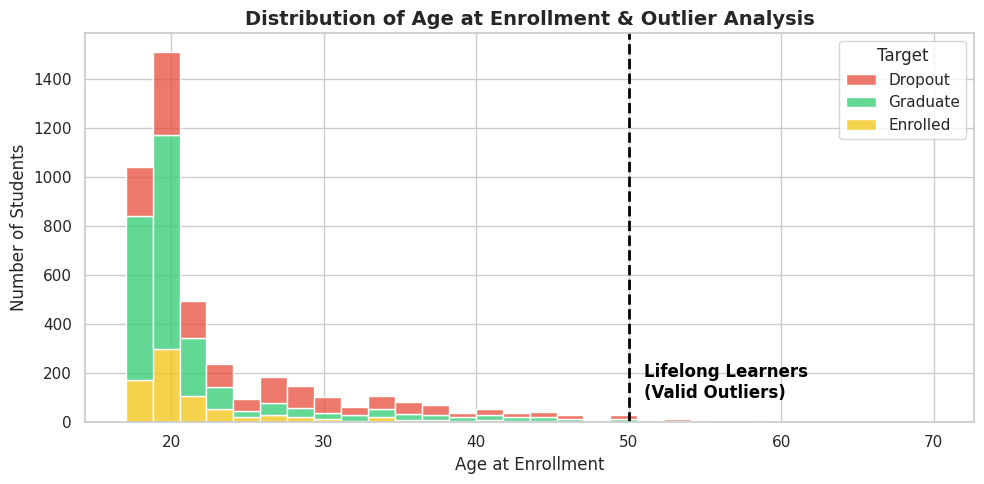

 Insight: The long tail to the right (>50 years) represents 'Lifelong Learners'. These are not data errors; they are real students, often struggling to graduate (High Dropout Rate in Red).


In [13]:
# =============================================================================
#  OUTLIER ANALYSIS: AGE DISTRIBUTION (Validating The "Tail")
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Grafik Ayarları
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# 1. Histogram (Stacked by Target)
# Shows that older students exist and have specific outcomes (mostly Dropout/Enrolled)
ax = sns.histplot(
    data=df,
    x='Age at enrollment',
    hue='Target',
    multiple="stack",
    bins=30,
    palette={'Dropout': '#e74c3c', 'Enrolled': '#f1c40f', 'Graduate': '#2ecc71'}
)

# 2. Outlier Line & Annotation
# We mark age 50 to show that data points beyond this are NOT errors, but adult students.
plt.axvline(x=50, color='black', linestyle='--', linewidth=2)

plt.text(51, 100, 'Lifelong Learners\n(Valid Outliers)',
         fontsize=12, color='black', fontweight='bold')

# English Titles and Labels
plt.title('Distribution of Age at Enrollment & Outlier Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Age at Enrollment')
plt.ylabel('Number of Students')

plt.tight_layout()
plt.show()

print(" Insight: The long tail to the right (>50 years) represents 'Lifelong Learners'. These are not data errors; they are real students, often struggling to graduate (High Dropout Rate in Red).")

#  DATASET OVERVIEW & FEATURE CORRELATIONS
THIS PRELIMINARY ANALYSIS PROVIDES A MACRO VIEW OF THE DATASET STRUCTURE AND IDENTIFIES THE STRONGEST STATISTICAL RELATIONSHIPS BETWEEN STUDENT FEATURES AND ACADEMIC OUTCOMES.
 KEY METRICS & ANALYTICS:
CLASS DISTRIBUTION ANALYSIS: QUANTIFIES THE BALANCE BETWEEN DROPOUT, ENROLLED, AND GRADUATE CLASSES TO ENSURE THE MODEL IS NOT BIASED TOWARDS A DOMINANT GROUP.

TARGET-CENTRIC CORRELATION: MAPS CATEGORICAL TARGETS TO NUMERIC VALUES TO IDENTIFY WHICH VARIABLES HAVE THE STRONGEST POSITIVE OR NEGATIVE IMPACT ON STUDENT SUCCESS.

HIGH-DIMENSIONAL HEATMAP: VISUALIZES THE TOP 20 MOST INFLUENTIAL FEATURES, INCLUDING NEWLY ENGINEERED VARIABLES LIKE "FINANCIAL PRESSURE" AND "SUCCESS RATE."

FEATURE ENGINEERING VALIDATION: PROVIDES STATISTICAL PROOF THAT OUR CUSTOM FEATURES ARE STRONGER PREDICTORS THAN THE RAW DATA, JUSTIFYING THE COMPLEX MODELING PHASE.

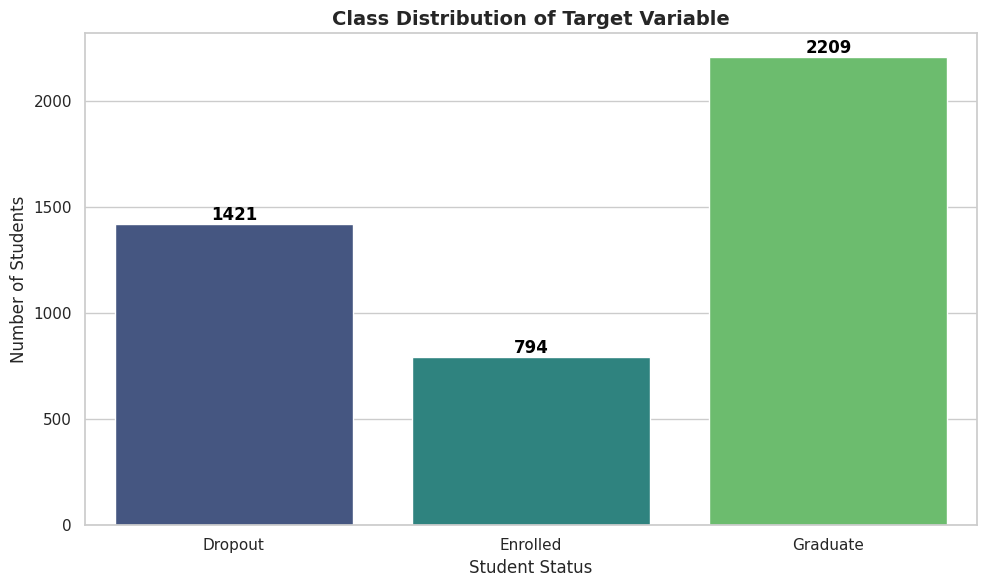

 Insight: Shows the balance of classes. Note if one class dominates.


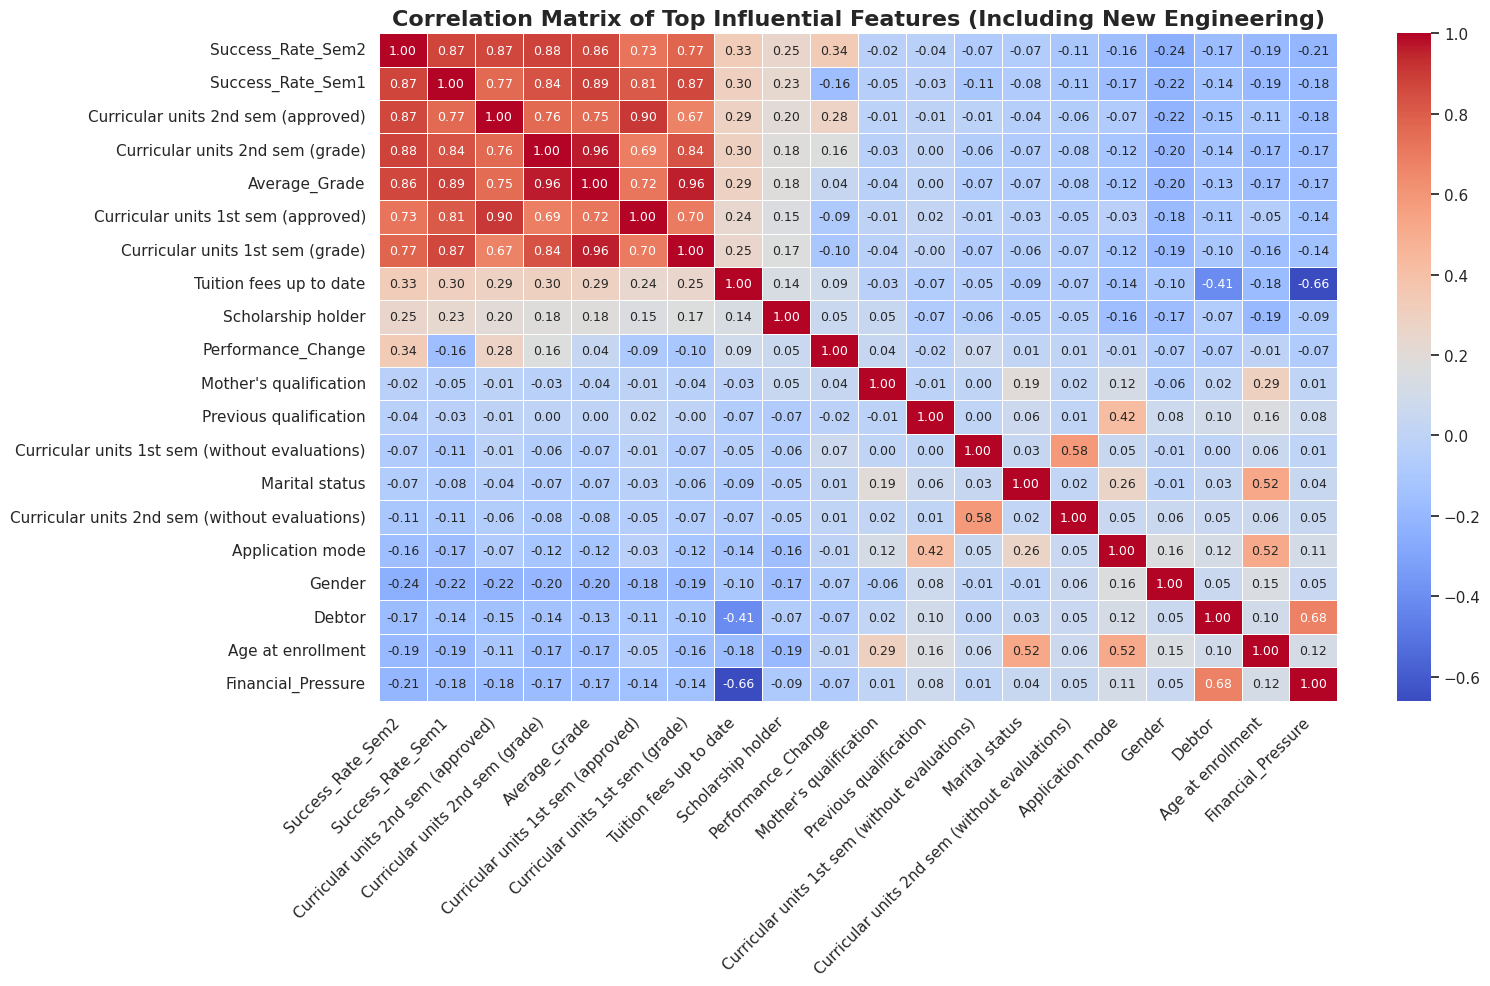

 Validation: Check the axes. If you see 'Financial_Pressure' or 'Success_Rate' here, it proves your Feature Engineering worked successfully.


In [14]:
# =============================================================================
# DATASET OVERVIEW & FEATURE CORRELATIONS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# General Style Settings
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11})

# ---------------------------------------------------------
# CHART 1: TARGET VARIABLE DISTRIBUTION
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Countplot with Viridis palette
ax = sns.countplot(
    x='Target',
    data=df,
    palette='viridis',
    order=['Dropout', 'Enrolled', 'Graduate']
)

# English Titles and Labels
plt.title('Class Distribution of Target Variable', fontsize=14, fontweight='bold')
plt.xlabel('Student Status')
plt.ylabel('Number of Students')

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()
print(" Insight: Shows the balance of classes. Note if one class dominates.")

# ---------------------------------------------------------
# CHART 2: CORRELATION HEATMAP (Top Influencers Only)
# ---------------------------------------------------------

# 1. Map Target to Numeric for Correlation
if df['Target'].dtype == 'O':
    mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
    df_corr = df.copy()
    df_corr['Target'] = df_corr['Target'].map(mapping)
else:
    df_corr = df.copy()

# 2. Calculate Correlation
# Select only numeric columns to avoid errors
numeric_df = df_corr.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['Target'].sort_values(ascending=False)

# 3. Filter: Top 10 Positive & Top 10 Negative Features
# This ensures we see our new engineered features if they are impactful
top_corr_features = correlations.index[1:11] # Exclude Target itself (index 0)
top_corr_features = top_corr_features.append(correlations.index[-10:])

# 4. Plot Heatmap
plt.figure(figsize=(16, 10))

sns.heatmap(
    numeric_df[top_corr_features].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 9}
)

plt.title('Correlation Matrix of Top Influential Features (Including New Engineering)', fontsize=16, fontweight='bold')

# Rotate labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

print(" Validation: Check the axes. If you see 'Financial_Pressure' or 'Success_Rate' here, it proves your Feature Engineering worked successfully.")